## test task: 测试MILP问题解决以及最终划分结果展示

In [1]:
from pyEnergy.cluster import kmeans_elbow
from pyEnergy.fool import initialize
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, value 


In [1]:

def reduce_signals(signals, threshold):
    """对信号进行平滑处理，这里使用 Savitzky-Golay 滤波器来代替 MATLAB 的平滑"""
    smoothed_signals = savgol_filter(signals, window_length=7, polyorder=3)
    return np.where(smoothed_signals > threshold, smoothed_signals, 0), smoothed_signals

def signal_composition_opt1(realP_perClster, signal_reduced):
    """使用 MILP 优化将信号分解为不同聚类信号的线性组合"""
    sols = []
    n_clusters = realP_perClster.shape[0]
    
    # 遍历每个时刻的信号进行优化
    for signal in signal_reduced:
        # 定义 MILP 问题
        prob = LpProblem("Signal——Decomposition", LpMinimize)
        
        # 定义优化变量（线性组合的系数）
        x = [LpVariable(f'x_{i}', lowBound=0, cat='Integer') for i in range(n_clusters)]
        
        # 目标函数：最小化 (targetP - CX)
        prob += lpSum([(realP_perClster[i] * x[i]) for i in range(n_clusters)]) - signal
        
        # 求解问题
        prob.solve()
        
        # 保存最优解
        sols.append([value(x[i]) for i in range(n_clusters)])
    
    return sols



In [3]:
# 初始化
fool = initialize("data/ChangErZhai-40-139079-values 20180101-20181031.csv")
y_pred = kmeans_elbow(*fool.features(), plot=False)

fool.feature["Cluster"] = y_pred
feature = fool.feature


Number of clusters: 2, Silhouette Score: 0.6384
Number of clusters: 3, Silhouette Score: 0.4046
Number of clusters: 4, Silhouette Score: 0.3398
Number of clusters: 5, Silhouette Score: 0.3808
Number of clusters: 6, Silhouette Score: 0.3612
Number of clusters: 7, Silhouette Score: 0.3751
Number of clusters: 8, Silhouette Score: 0.3786
Number of clusters: 9, Silhouette Score: 0.3598
Number of clusters: 10, Silhouette Score: 0.3558
n_clusters: 2, score: 0.6383900492559629


In [4]:
feature

,std. real power(ss),ave. real power(ss),max. real power(tr),std. reactive power(ss),ave. reactive power(ss),max. reactive power(tr),std. phase B current(ss),ave. phase B current(ss),max. phase B current(tr),Cluster
0,0.504825,-0.334844,-0.236018,1.087903,-0.270951,-0.264526,-0.145479,-0.411253,-0.27594,0
1,-0.1246,-0.315711,-0.299541,0.128566,-0.487188,-0.542485,-0.067267,-0.428752,-0.433393,0
2,-0.899,-0.31348,-0.319402,-1.264301,-0.395523,-0.640283,-0.574594,-0.418442,-0.444781,0
3,-0.786107,-0.334862,-0.30555,-1.147458,-0.460763,-0.524405,-0.531058,-0.433467,-0.4277,0
4,0.410218,-0.391474,-0.354438,1.186974,-0.334029,-0.121131,-0.414687,-0.428468,-0.492333,0
...,...,...,...,...,...,...,...,...,...,...
117,-0.977356,0.202501,0.119846,-1.454601,0.613768,0.459787,-0.667333,0.350116,0.259584,1
118,-0.788531,0.186898,0.087505,-1.219963,0.618184,0.415647,-0.542921,0.329884,0.206495,1
119,-0.154261,-1.284586,-1.398885,0.754669,-1.448434,-1.561987,-0.108902,-1.496621,-1.552118,0
120,0.030899,-1.222181,-1.237952,0.226576,-1.599111,-1.596583,-0.372419,-1.405695,-1.439338,0


In [5]:

realP_perClster = feature.groupby('Cluster')["ave. real power(ss)"].mean()
# TODO: workingP = ?
realP_perClster

Cluster
0   -0.755714
1    0.545794
Name: ave. real power(ss), dtype: object

In [6]:

other_events = fool.other_event
residues_final = np.zeros(len(other_events))  # 用于存储每个事件的残差
thr_val = 5 # why five?



In [9]:
def reconstruct_time_series(sols, realP_perClster):
    """重构时间序列数据"""
    return np.dot(sols, realP_perClster)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/envs/nilm/lib/python3.8/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/0z/hx_5jw4n6qj35n3s1_qd40xw0000gn/T/dd432db080b84538a5da7cde81d348a0-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/0z/hx_5jw4n6qj35n3s1_qd40xw0000gn/T/dd432db080b84538a5da7cde81d348a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 5 COLUMNS
At line 8 RHS
At line 9 BOUNDS
At line 10 ENDATA
Problem MODEL has 0 rows, 2 columns and 0 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Empty problem - 0 rows, 2 columns and 0 elements
Dual infeasible - objective value 0
DualInfeasible objective 0 - 0 iterations time 0.002

Result - Linear relaxation unbounded

Enumerated nodes:           0
Total iterations:           0
Time (CPU seconds):         0.00
Time (Wallclock Seconds):   0.00

Option for print

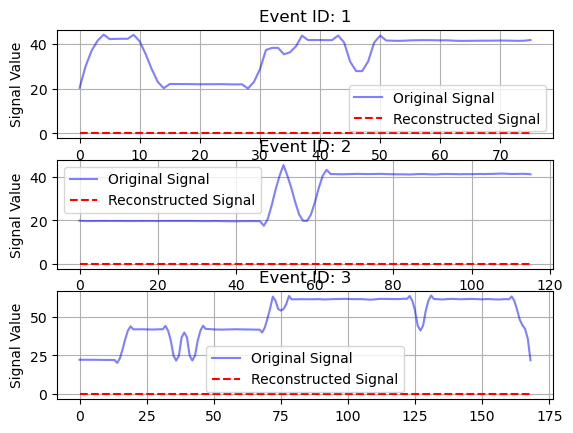

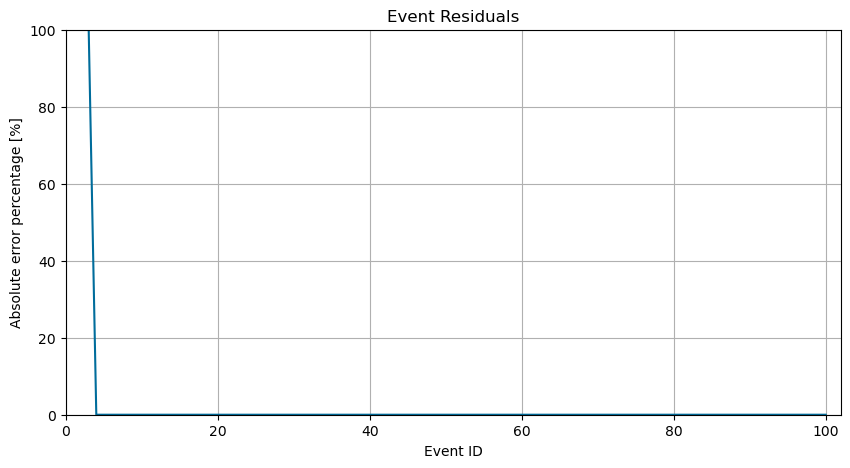

In [12]:
print(f"other events num: {len(other_events)}")
other_events = other_events[:3]
for ii, event_ in enumerate(other_events):
    signals = event_['curnt_B']
    signal_reduced, _ = reduce_signals(signals, thr_val)
    
    sols = signal_composition_opt1(realP_perClster, signal_reduced)
    reconstructed_signal = reconstruct_time_series(sols, realP_perClster)

    # 计算残差
    residue_perPulse_norm = abs((reconstructed_signal - signal_reduced) / signal_reduced)
    residues_final[ii] = np.mean(residue_perPulse_norm)

    # 绘制原始信号和重构信号
    plt.subplot(len(other_events), 1, ii + 1)
    plt.plot(signal_reduced, label='Original Signal', color='blue', alpha=0.5)
    plt.plot(reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='--')
    plt.title(f'Event ID: {ii + 1}')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.tight_layout()
    plt.grid()

# 绘制残差
plt.figure()
plt.plot(residues_final * 100, linewidth=1.5, color=[0/255, 108/255, 155/255])
plt.grid(True)
plt.xlim([0, len(residues_final) + 1])
plt.ylim([0, 100])
plt.ylabel('Absolute error percentage [%]')
plt.xlabel('Event ID')
plt.title('Event Residuals')
plt.show()

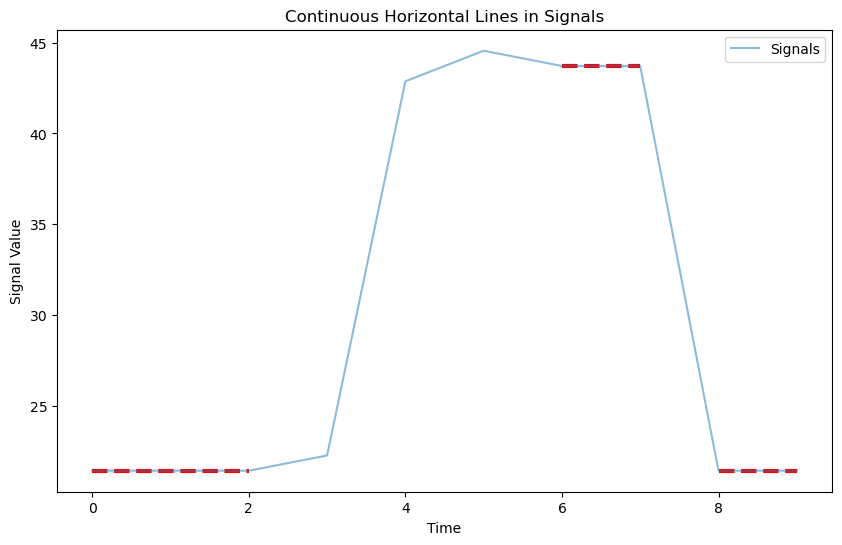

In [8]:
import numpy as np
import matplotlib.pyplot as plt


# 使用示例
signals = np.array([21.43458596, 21.43458596, 21.43458596, 22.27574283, 42.86917193, 44.55148566, 43.7103288,
                    43.7103288, 21.43458596, 21.43458596])  # 替换为你的信号数据
plot_continuous_lines(signals)
